In [1]:
%matplotlib inline

import numpy as np
import skimage.transform
import torch
import torch.nn as nn
import torch.nn. functional as F

from PIL import Image
from matplotlib.pyplot import imshow
from torchvision import models, transforms
from torchvision.utils import save_image

from cam import CAM, GradCAM, GradCAMpp, SmoothGradCAMpp, SaveValues
from utils.visualize import visualize, reverse_normalize
from utils.imagenet_labels import label2idx, idx2label

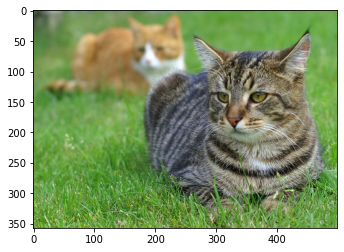

In [5]:
# from ImageNet
image = Image.open('./sample/tigercat.jpg')
# image = Image.open('./sample/dogsled.jpg')
imshow(image)

In [6]:
# preprocessing. mean and std from ImageNet
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

preprocess = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

In [7]:
# convert image to tensor
tensor = preprocess(image)

# reshape 4D tensor (N, C, H, W)
tensor = tensor.unsqueeze(0).cuda()

In [13]:
model = models.resnet18(pretrained=True)
model.eval()
model.cuda()
# print(model)
1

1

In [14]:
score = model(tensor)

In [15]:
_, idx = torch.max(score, dim=1)

In [16]:
idx

tensor([282], device='cuda:0')

In [17]:
model.layer1[1].conv1

Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

In [18]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [21]:
# the target layer you want to visualize
target_layer = model.layer4[1].conv2

# wrapper for class activation mapping. Choose one of the following.
# wrapped_model = CAM(model, target_layer)
wrapped_model =GradCAM(model, target_layer)
# wrapped_model = GradCAMpp(model, target_layer)
# wrapped_model = SmoothGradCAMpp(model, target_layer, n_samples=25, stdev_spread=0.15)

In [22]:
cam, idx = wrapped_model(tensor)

predicted class ids 282	 probability 0.4645325243473053
torch.Size([1, 512, 12, 16]) torch.Size([1, 512, 12, 16])


In [78]:
cam.shape

torch.Size([1, 1, 12, 16])

In [79]:
from torchsummary import summary

In [80]:
tensor.shape

torch.Size([1, 3, 357, 499])

In [81]:
summary(model, tensor.shape[1:])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 179, 250]           9,408
       BatchNorm2d-2         [-1, 64, 179, 250]             128
              ReLU-3         [-1, 64, 179, 250]               0
         MaxPool2d-4          [-1, 64, 90, 125]               0
            Conv2d-5          [-1, 64, 90, 125]          36,864
       BatchNorm2d-6          [-1, 64, 90, 125]             128
              ReLU-7          [-1, 64, 90, 125]               0
            Conv2d-8          [-1, 64, 90, 125]          36,864
       BatchNorm2d-9          [-1, 64, 90, 125]             128
             ReLU-10          [-1, 64, 90, 125]               0
       BasicBlock-11          [-1, 64, 90, 125]               0
           Conv2d-12          [-1, 64, 90, 125]          36,864
      BatchNorm2d-13          [-1, 64, 90, 125]             128
             ReLU-14          [-1, 64, 

In [22]:
print(idx2label[idx])

tiger cat


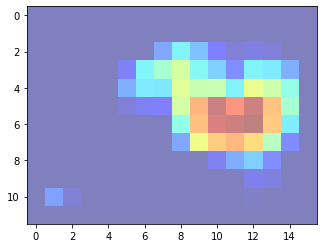

In [23]:
# visualize only cam
imshow(cam.squeeze().numpy(), alpha=0.5, cmap='jet')

In [10]:
# reverse normalization for display
img = reverse_normalize(tensor)

In [11]:
heatmap = visualize(img, cam)

In [76]:
heatmap.shape

torch.Size([1, 3, 357, 499])

In [12]:
# save image
# save_image(heatmap, './sample/{}_cam.png'.format(idx2label[idx]).replace(" ", "_").replace(",", ""))
# save_image(heatmap, './sample/{}_gradcam.png'.format(idx2label[idx]).replace(" ", "_").replace(",", ""))
# save_image(heatmap, './sample/{}_gradcampp.png'.format(idx2label[idx]).replace(" ", "_").replace(",", ""))
save_image(heatmap, './sample/{}_smoothgradcampp.png'.format(idx2label[idx]).replace(" ", "_").replace(",", ""))

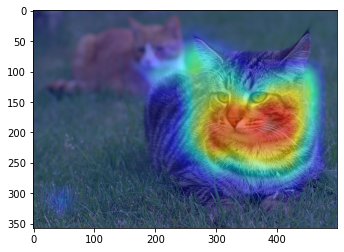

In [19]:
imshow(heatmap[0].numpy().transpose(1, 2, 0))

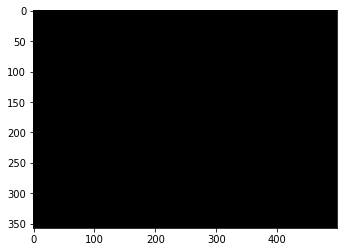

In [13]:
# or visualize on Jupyter
hm = (heatmap.squeeze().numpy().transpose(1, 2, 0)).astype(np.int32)
imshow(hm)